<a href="https://colab.research.google.com/github/EchenimEdwin/https-github.com-users-EchenimEdwin-/blob/main/LSTM_for_Time_Series_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

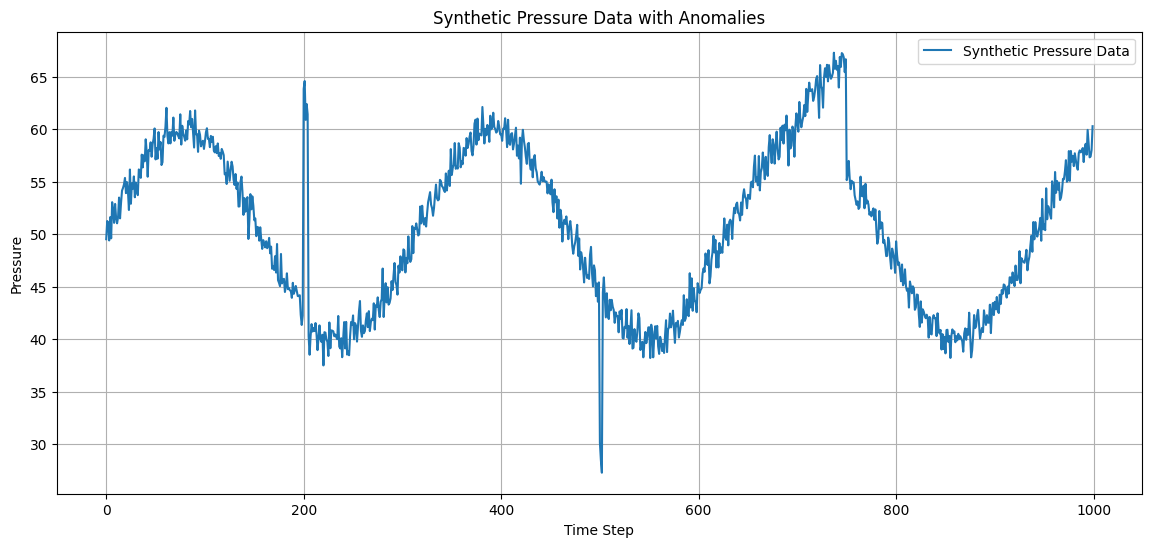

X_train shape: (792, 10, 1)
y_train shape: (792,)
X_test shape: (198, 10, 1)
y_test shape: (198,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2863 - val_loss: 0.0955
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0381 - val_loss: 0.0054
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - val_loss: 0.0037
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0147 - val_loss: 0.0037
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134 - val_loss: 0.0034
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - val_loss: 0.0034
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - val_loss: 0.0034
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0040
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - val_loss: 0.0033
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

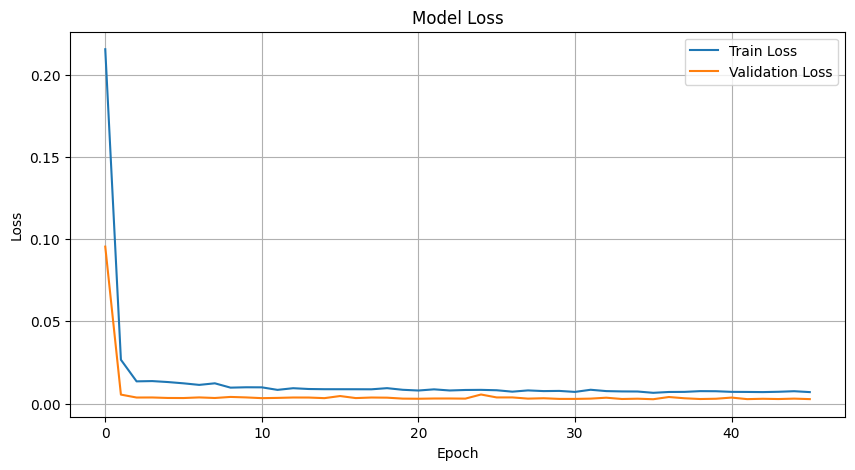

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Anomaly Threshold: 6.40
Number of detected anomalies: 15


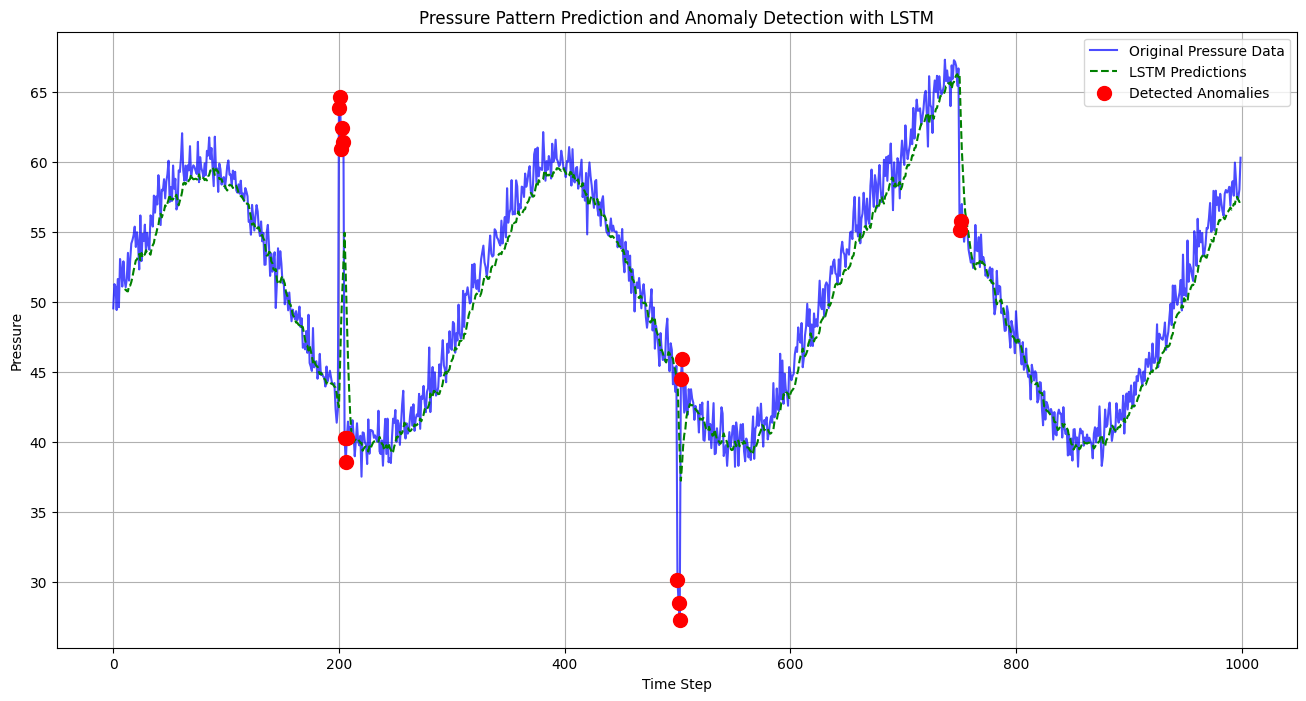

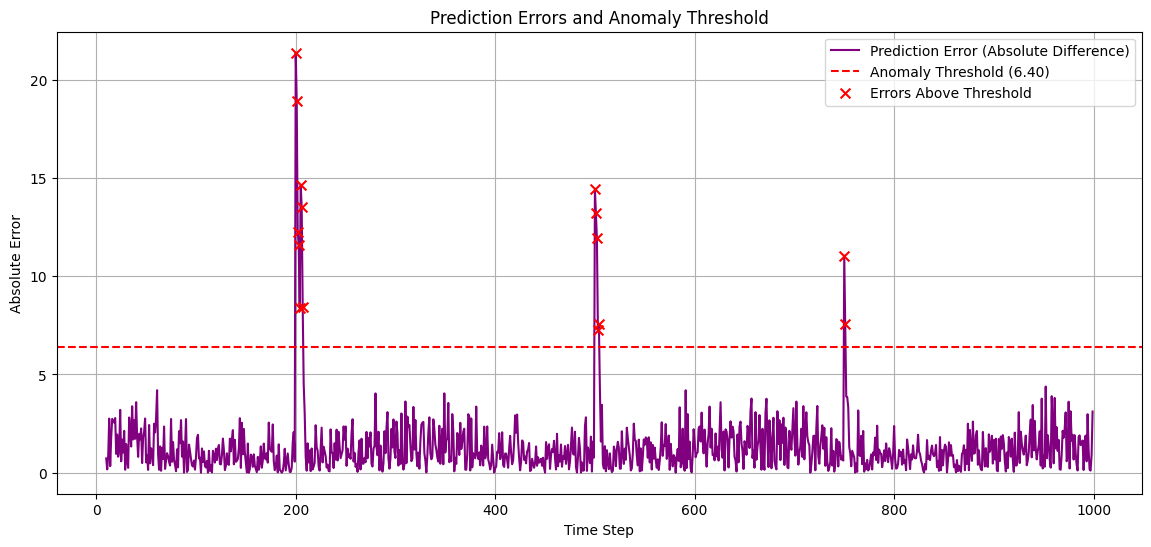

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Generate Synthetic Time Series Data ---
# We'll create a synthetic pressure pattern with some anomalies for demonstration.
def generate_pressure_data(num_points=1000):
    time = np.arange(0, num_points)
    # Base sinusoidal pattern
    pressure = 10 * np.sin(time / 50) + 50
    # Add some noise
    pressure += np.random.normal(0, 1, num_points)

    # Introduce anomalies
    # Sudden spikes
    pressure[200:205] += 20
    pressure[500:503] -= 15
    # Gradual shift
    pressure[700:750] += np.linspace(0, 10, 50)

    return pressure

pressure_data = generate_pressure_data()
time_steps = np.arange(len(pressure_data))

plt.figure(figsize=(14, 6))
plt.plot(time_steps, pressure_data, label='Synthetic Pressure Data')
plt.title('Synthetic Pressure Data with Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Pressure')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Data Preprocessing for LSTM ---
# LSTMs work best with scaled data and sequential input.

# Normalize the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pressure_data.reshape(-1, 1))

# Create sequences for the LSTM model
# The LSTM will learn to predict the next value based on 'n_steps' previous values.
n_steps = 10  # Number of previous time steps to consider for prediction

X, y = [], []
for i in range(len(scaled_data) - n_steps):
    X.append(scaled_data[i:(i + n_steps), 0])
    y.append(scaled_data[i + n_steps, 0])

X = np.array(X)
y = np.array(y)

# Reshape input to be [samples, time_steps, features] for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# --- 3. Build the LSTM Model ---
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dropout(0.2)) # Dropout for regularization to prevent overfitting
model.add(Dense(units=1)) # Output layer predicts a single value (the next pressure reading)

model.compile(optimizer='adam', loss='mse') # Adam optimizer and Mean Squared Error loss
model.summary()

# --- 4. Train the Model ---
# Use EarlyStopping to prevent overfitting and stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Predict and Detect Anomalies ---
# Make predictions on the entire scaled dataset
predictions_scaled = model.predict(X)

# Inverse transform the predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual_values = pressure_data[n_steps:] # Adjust actual values to match prediction length

# Calculate prediction errors (residuals)
errors = np.abs(actual_values - predictions.flatten())

# Define an anomaly threshold
# A common approach is to use a multiple of the standard deviation of errors
# or a percentile. Here, we'll use a simple fixed threshold for demonstration.
# In a real-world scenario, this threshold would be determined empirically
# or using statistical methods (e.g., IQR, z-score).
anomaly_threshold = np.mean(errors) + 3 * np.std(errors)
print(f"\nAnomaly Threshold: {anomaly_threshold:.2f}")

# Identify anomalies
anomaly_indices = np.where(errors > anomaly_threshold)[0]
# Adjust anomaly indices to reflect their position in the original pressure_data array
original_anomaly_indices = anomaly_indices + n_steps

print(f"Number of detected anomalies: {len(original_anomaly_indices)}")

# --- 6. Visualize Results ---
plt.figure(figsize=(16, 8))
plt.plot(time_steps, pressure_data, label='Original Pressure Data', color='blue', alpha=0.7)
plt.plot(time_steps[n_steps:], predictions, label='LSTM Predictions', color='green', linestyle='--')

# Plot detected anomalies
plt.scatter(original_anomaly_indices, pressure_data[original_anomaly_indices],
            color='red', s=100, marker='o', label='Detected Anomalies', zorder=5)

plt.title('Pressure Pattern Prediction and Anomaly Detection with LSTM')
plt.xlabel('Time Step')
plt.ylabel('Pressure')
plt.legend()
plt.grid(True)
plt.show()

# Detailed plot of errors and threshold
plt.figure(figsize=(14, 6))
plt.plot(time_steps[n_steps:], errors, label='Prediction Error (Absolute Difference)', color='purple')
plt.axhline(y=anomaly_threshold, color='red', linestyle='--', label=f'Anomaly Threshold ({anomaly_threshold:.2f})')
plt.scatter(original_anomaly_indices, errors[anomaly_indices],
            color='red', s=50, marker='x', label='Errors Above Threshold', zorder=5)
plt.title('Prediction Errors and Anomaly Threshold')
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.show()